<a href="https://colab.research.google.com/github/j-d-0630/Pytorch/blob/main/quick_start.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!pip install optuna

In [17]:
%matplotlib inline
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import optuna
optuna.logging.disable_default_handler()

In [13]:
# 訓練データをdatasetsからダウンロード
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# テストデータをdatasetsからダウンロード
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [14]:
batch_size = 128

# データローダーの作成
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([128, 3, 32, 32])
Shape of y:  torch.Size([128]) torch.int64


<class 'torch.Tensor'>
<class 'numpy.ndarray'>
(3, 546, 274)
(546, 274, 3)


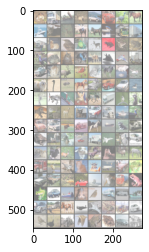

 frog truck truck  deer


In [15]:
# ダウンロードした画像を表示してみる
classes = training_data.classes
def imshow(img):
    # 非正規化する
    img = img / 2 + 0.5
    # torch.Tensor型からnumpy.ndarray型に変換する
    print(type(img)) # <class 'torch.Tensor'>
    npimg = img.numpy()
    print(type(npimg))    
    # 形状を（RGB、縦、横）から（縦、横、RGB）に変換する
    print(npimg.shape)
    npimg = np.transpose(npimg, (1, 2, 0))
    print(npimg.shape)
    # 画像を表示する
    plt.imshow(npimg)
    plt.show()

dataiter = iter(train_dataloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [16]:
# 訓練に際して、可能であればGPU（cuda）を設定します。GPUが搭載されていない場合はCPUを使用します
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


In [18]:
# modelを定義します
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3,512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=10, bias=True)
    (7): ReLU()
  )
)


In [19]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # 損失誤差を計算
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # バックプロパゲーション
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # if batch % 100 == 0:
        #     loss, current = loss.item(), batch * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return 1- correct

In [27]:
def objective(trial):
  #整数値の試行を行うパラメータ
  param1 = trial.suggest_int("epochs", 5, 10)

  for step in range(param1):
    train(train_dataloader, model, loss_fn, optimizer)
    error_rate = test(test_dataloader, model)

  return error_rate

In [28]:
TRIAL_SIZE = 10
study = optuna.create_study()
study.optimize(objective, n_trials=TRIAL_SIZE)

In [29]:
study.best_params

{'epochs': 10}

In [30]:
study.best_value

0.6759999999999999

In [ ]:
# epochs = 5
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train(train_dataloader, model, loss_fn, optimizer)
#     test(test_dataloader, model)
# print("Done!")

Epoch 1
-------------------------------
loss: 2.298609  [    0/50000]
loss: 2.301140  [ 6400/50000]
loss: 2.303730  [12800/50000]
loss: 2.298307  [19200/50000]
loss: 2.302159  [25600/50000]
loss: 2.300839  [32000/50000]
loss: 2.300896  [38400/50000]
loss: 2.302072  [44800/50000]
Test Error: 
 Accuracy: 15.4%, Avg loss: 0.036113 

Epoch 2
-------------------------------
loss: 2.297062  [    0/50000]
loss: 2.298376  [ 6400/50000]
loss: 2.300793  [12800/50000]
loss: 2.298538  [19200/50000]
loss: 2.299929  [25600/50000]
loss: 2.299857  [32000/50000]
loss: 2.299940  [38400/50000]
loss: 2.300543  [44800/50000]
Test Error: 
 Accuracy: 15.9%, Avg loss: 0.036081 

Epoch 3
-------------------------------
loss: 2.294398  [    0/50000]
loss: 2.295773  [ 6400/50000]
loss: 2.298504  [12800/50000]
loss: 2.297704  [19200/50000]
loss: 2.297794  [25600/50000]
loss: 2.298471  [32000/50000]
loss: 2.298846  [38400/50000]
loss: 2.299527  [44800/50000]
Test Error: 
 Accuracy: 16.5%, Avg loss: 0.036049 

Epoc